In [25]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import time
import torch.nn.functional as F
import os
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score

# Add the root directory to the sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Now you should be able to import from src.utils.features
from src.utils.features import TextCleaner, EmbeddingGenerator, FeatureAdder

In [2]:
gdf = pd.read_parquet("../data/processed/eda2.parquet")
threshold = 10000

(gdf["price"]>threshold).sum()/len(gdf)

gdf = gdf[gdf["price"]<threshold]

top_1_percent_price = 8000.0 

gdf["is_luxury"] = (gdf["price"] > top_1_percent_price).astype(int)


seed = 42  # Fix seed for reproducibility of the split

# First Split: Train/Test
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, test_index in stratified_split.split(gdf, gdf['borough']):
    data_train_val = gdf.iloc[train_index]
    data_test = gdf.iloc[test_index]

# Second Split: Train/Validation
stratified_split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=seed)

for train_index, test_index in stratified_split2.split(data_train_val, data_train_val['borough']):
    data_train = data_train_val.iloc[train_index]  # Features for training
    data_val = data_train_val.iloc[test_index]

In [3]:
pt = PowerTransformer(method='yeo-johnson') # Target transform

text_pipeline = Pipeline([
    ('text_cleaner', TextCleaner()),  # Text cleaning
    ('embedding_generator', EmbeddingGenerator()),  # Embedding generation
    ('pca', PCA(n_components=0.95))  # PCA on embeddings (can be removed)
])

cat_columns = ["bedrooms", "bathrooms", "zone", "borough", "propertyType", "furnishType", "NoiseClass"]
bin_columns = ["letType", "deposit", "TFL1", "TFL2", "TFL3", "RAIL1", "RAIL2", "RAIL3","is_luxury"]
distances = ["distance_to_center", "distance_to_station1", "distance_to_station2", "distance_to_station3"]


# Define the pipeline for feature transformations 
transformer_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('feature_adder', FeatureAdder(), ['angle_from_center', 'latitude', 'longitude']),
        # ('text', text_pipeline, 'description'),
        ('categorical', OneHotEncoder(categories='auto', handle_unknown='ignore', sparse_output=False, drop='first'), cat_columns),
        ('binary_features', OneHotEncoder(categories='auto', handle_unknown='ignore', sparse_output=False, drop='first'), bin_columns),
        ('min_max', MinMaxScaler(), distances),
    ])),
])

In [4]:
X_train = transformer_pipeline.named_steps['preprocessor'].fit_transform(data_train)
X_val = transformer_pipeline.named_steps['preprocessor'].transform(data_val)
X_test = transformer_pipeline.named_steps['preprocessor'].transform(data_test)


Y_train = pt.fit_transform(data_train["price"].values.reshape(-1, 1))
Y_val = pt.transform(data_val["price"].values.reshape(-1, 1))
Y_test = pt.transform(data_test["price"].values.reshape(-1, 1))

In [5]:
X_train.shape, X_val.shape, X_test.shape

((19371, 89), (3419, 89), (5698, 89))

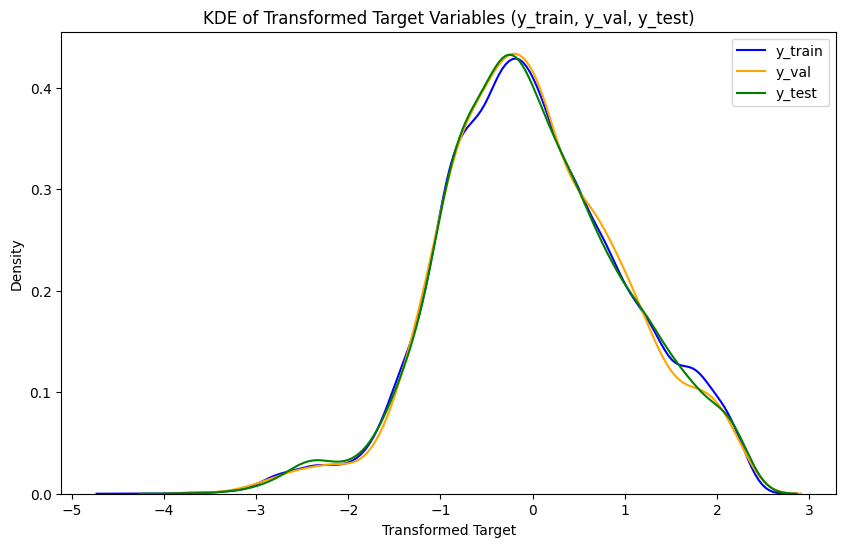

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(Y_train.flatten(), label='y_train', color='blue', fill=False)
sns.kdeplot(Y_val.flatten(), label='y_val', color='orange', fill=False)
sns.kdeplot(Y_test.flatten(), label='y_test', color='green',fill=False)

plt.title('KDE of Transformed Target Variables (y_train, y_val, y_test)')
plt.xlabel('Transformed Target')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
import wandb


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [7]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).to(device)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32).to(device)

# Create DataLoader for batching
train_data = TensorDataset(X_train_tensor, Y_train_tensor)
val_data = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
print(f"Using device: {device}")

Using device: cuda


In [35]:

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        
        # Input Layer
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        
        # Hidden Layers
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        
        # Output Layer
        self.fc5 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        return self.fc5(x)



In [ ]:
model = SimpleNN(input_dim=X_train.shape[1])
model.to(device)
wandb.watch(model, log_freq=100)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


num_epochs = 50
start_time = time.time()

# Initialize W&B
wandb.init(project='debug_nn', entity='anufriievsergey-ucl',reinit=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training phase
    for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item()
    
    # Log loss after every epoch
    train_loss = running_loss / len(train_loader)
    wandb.log({'train_loss': train_loss, 'epoch': epoch})
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            val_loss += loss.item()
    
    val_loss = val_loss / len(val_loader)
    wandb.log({'val_loss': val_loss, 'epoch': epoch})
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


In [27]:
y_pred = model(X_test_tensor).squeeze().cpu().detach().numpy()

print(y_pred.mean())
print(y_pred.var())

-0.000709394
0.00017758661


<!-- FEATURES:
  numerical_features: 
    - "latitude"
    - "longitude"
    - "distance_to_center"
    - "angle_from_center"
    - "distance_to_station1"
    - "distance_to_station2"
    - "distance_to_station3"
  
  categorical_features:
    - "bedrooms"
    - "bathrooms"
    - "deposit"
    - "zone"
    - "borough"
    - "propertyType"
    - "furnishType"
    - "NoiseClass"
    - "letType"
    - "TFL1"
    - "TFL2"
    - "TFL3"
    - "RAIL1" 
    - "RAIL2"
    - "RAIL3" -->
